
# Install tensorflow

In [1]:
!pip install tensorflow==2.6.2

     |████████████████████████████████| 458.3 MB 2.4 kB/s 
     |████████████████████████████████| 1.3 MB 48.5 MB/s 
     |████████████████████████████████| 462 kB 69.5 MB/s 
     |████████████████████████████████| 5.6 MB 38.4 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=2dd15a0fa4b4870bbf139c7495d3b58c2204cdea12a4d5672ad447f47403499b
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68720 sha256=88afb76254e90e3735ead51e8a36f579043702d7a65682a4ea3529da80ad0976
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attemptin

In [ ]:
!pip install git+https://github.com/tensorflow/docs

# Autoencoders

Autoencoders are neural networks trained to reproduce the input: the model is a regressor where the target is the same as the input.

Autoencoders can be used to find lower-dimensional representation of the data. In this case, one of the hidden layers, typically the middle one, is the "code", i.e. the compressed representation of the input data.

![picture](https://drive.google.com/uc?id=1drlrT_f2_sAX1u65npWWv2wOLti8NfVs)

Contary to PCA, autoencoders are powerful non-linear models that can discover non-linear correlations among features.

![picture](https://drive.google.com/uc?id=1og8kGSLkSnKIeUKg1xSAfmv5JFfIZNIt)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np 

In [3]:
tf.__version__

'2.6.2'

In [4]:
%load_ext tensorboard
import tensorboard
tensorboard.__version__

'2.6.0'

In [5]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-niml49ay
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-niml49ay
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=157864 sha256=69603584aaf2c0d93c91b8f957b30fe1969ced427307a327612fc3d272b3a10b
  Stored in directory: /tmp/pip-ephem-wheel-cache-9jh2n2b3/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


# Sample problem : Mnist

Train a neural network model to encode images 28x28 pixels (768 pixels) representing **hand-written digits** in a 16-dimensional vector.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how much accurate is the lower representation. You can access the MNIST directly from TensorFlow. Import and load the MNIST data directly from TensorFlow:



In [6]:
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9.

## Explore the data
Image shape : 60,000 x 28 x 28

Each image is represented as a 2 dimensional matrix of 28 x 28

In [7]:
train_images.shape,len(train_labels)


((60000, 28, 28), 60000)

In [8]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [9]:
test_images.shape, len(test_labels)

((10000, 28, 28), 10000)

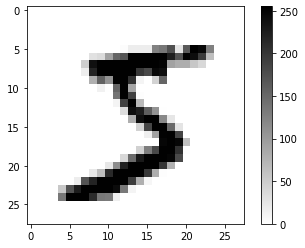

In [10]:
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


## Preprocess images
Normalize pixel values in the range [0, 1], i.e. divide by 255.

In [11]:
# important to perform each processing step separately on train and test 

train_images = train_images / 255.0

test_images = test_images / 255.0

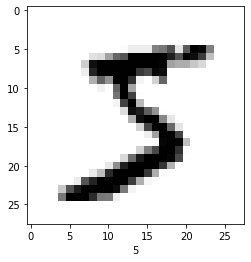

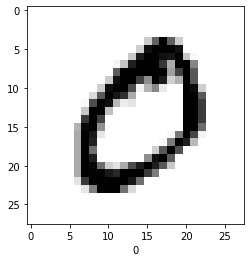

In [12]:
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.xlabel(train_labels[0])
plt.show()
plt.imshow(train_images[1], cmap=plt.cm.binary)
plt.xlabel(train_labels[1])
plt.show()


# Build the model and pipeline using Sequential API

## Setup layers

In [13]:
input_img = keras.Input(shape=(28, 28), name='image')
encoded = layers.Flatten(name='flatten')(input_img)
encoded = layers.Dense(128, activation='relu', name='enc_hidden')(encoded)
encoded = layers.Dense(16, activation='relu', name='enc_output')(encoded)

decoded = layers.Dense(128, activation='relu', name='dec_hidden')(encoded)
decoded = layers.Dense(784, activation='sigmoid', name='dec_output')(decoded)
decoded = layers.Reshape((28, 28), name='reshape')(decoded)

## Compile the model

Compiling the model means setting up the optimizer and loss function

* **Loss function** —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* **Optimizer** —This is how the model is updated based on the data it sees and its loss function.

In [14]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
enc_hidden (Dense)           (None, 128)               100480    
_________________________________________________________________
enc_output (Dense)           (None, 16)                2064      
_________________________________________________________________
dec_hidden (Dense)           (None, 128)               2176      
_________________________________________________________________
dec_output (Dense)           (None, 784)               101136    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0     

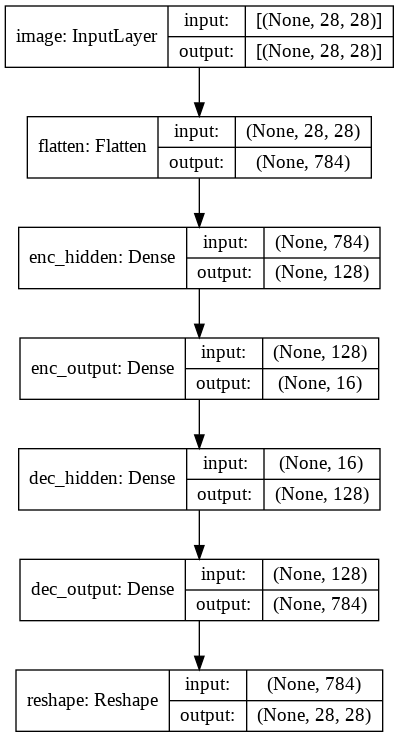

In [43]:
keras.utils.plot_model(autoencoder, show_shapes=True, show_layer_names=True)

# Train the model
Training the neural network model requires the following steps:

1. Feed the training data to the model. **In an autoencoder, the input is the same as the target** (`train_images`).
2. The model learns to encode the image information in a 16-dimensional vector and decode it back.
3. You ask the model to encode and decode the original images.
4. Verify that the original images resembles the recovered images.

In [17]:
# tensorboard settings to view plots
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


autoencoder.fit(train_images, train_images,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images, test_images))

Epoch 1/100
235/235 [==============================] - 5s 18ms/step - loss: 0.2383 - val_loss: 0.1630
Epoch 2/100
235/235 [==============================] - 4s 17ms/step - loss: 0.1490 - val_loss: 0.1375
Epoch 3/100
235/235 [==============================] - 4s 17ms/step - loss: 0.1331 - val_loss: 0.1269
Epoch 4/100
235/235 [==============================] - 4s 17ms/step - loss: 0.1255 - val_loss: 0.1217
Epoch 5/100
235/235 [==============================] - 4s 17ms/step - loss: 0.1215 - val_loss: 0.1188
Epoch 6/100
235/235 [==============================] - 4s 17ms/step - loss: 0.1190 - val_loss: 0.1163
Epoch 7/100
235/235 [==============================] - 4s 17ms/step - loss: 0.1169 - val_loss: 0.1147
Epoch 8/100
235/235 [==============================] - 4s 17ms/step - loss: 0.1152 - val_loss: 0.1130
Epoch 9/100
235/235 [==============================] - 4s 17ms/step - loss: 0.1137 - val_loss: 0.1120
Epoch 10/100
235/235 [==============================] - 4s 17ms/step - loss: 0.112

## Evaluate the model on test set

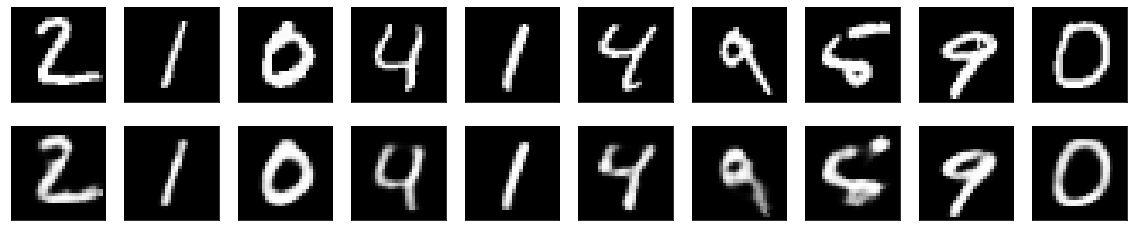

In [18]:
decoded_imgs = autoencoder.predict(test_images)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Embeddings
We use the trained layers in order to get the core representation in the middle layer of the autoencoder, and we represent them with the TSNE


In [19]:
embeddings = keras.Model(input_img, encoded).predict(test_images)

In [20]:
from sklearn.manifold import TSNE
import numpy as np

In [21]:
tsne = TSNE(n_components=2)

In [22]:
emb2d = tsne.fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [23]:
x,y = np.squeeze(emb2d[:, 0]), np.squeeze(emb2d[:, 1])

In [24]:
import pandas as pd

In [25]:
from matplotlib.cm import tab10

(-77.77186698913575, 93.32099266052246, -92.64457550048829, 91.07499542236329)

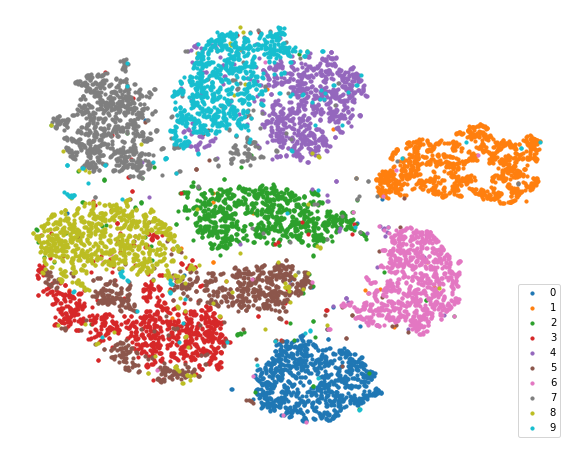

In [26]:
summary =  pd.DataFrame({"x": x, "y": y, "target": test_labels, "size": 10})

plt.figure(figsize=(10,8))

for key, sel in summary.groupby("target"):
    plt.scatter(sel["x"], sel["y"], s=10, color=tab10.colors[key], label=key)
    
plt.legend()
plt.axis("off")

# Add denoising
Autoencoders can be quite unstable when presented with even slightly different input distributions. In this example, we add Gaussian noise to the original images. They do seem very similar to the original images, yet the autoencoder fails to reproduce them.

Denoising Autoencoders (DAE) are more robust compared to "vanilla" autoencoders.

In [27]:
noise_factor = 0.1
x_train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) 
x_test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

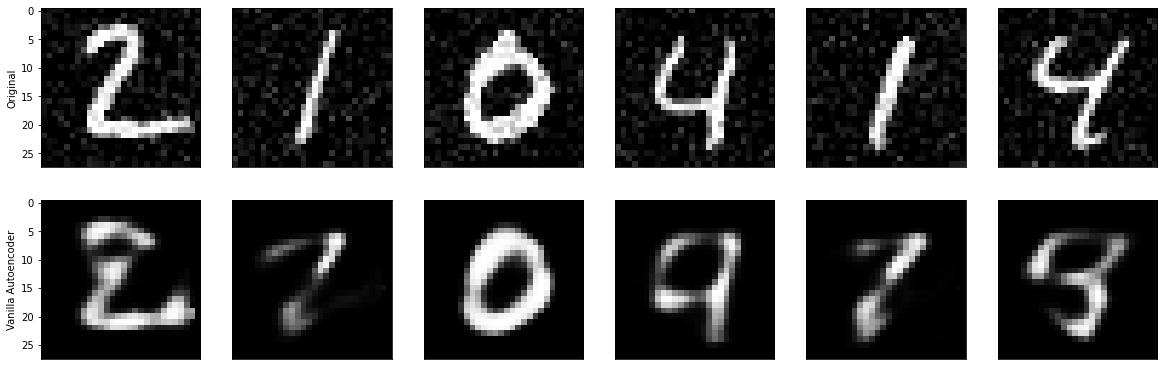

In [28]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 6
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Original")
    else:
        ax.get_yaxis().set_visible(False)
        
    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Vanilla Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
    
        
plt.show()

In [29]:
from tensorflow.keras.layers import GaussianNoise

In [30]:
input_img = keras.Input(shape=(28, 28), name='image')

noisy_input = GaussianNoise(0.1, name='gaussian_noise')(input_img)

encoded = layers.Flatten(name='flatten')(noisy_input)
encoded = layers.Dense(128, activation='relu', name='enc_hidden')(encoded)
encoded = layers.Dense(16, activation='relu', name='enc_output')(encoded)

decoded = layers.Dense(128, activation='relu', name='dec_hidden')(encoded)
decoded = layers.Dense(784, activation='sigmoid', name='dec_output')(decoded)
decoded = layers.Reshape((28, 28), name='reshape')(decoded)

In [31]:
noisy_autoencoder = keras.Model(input_img, decoded)
noisy_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

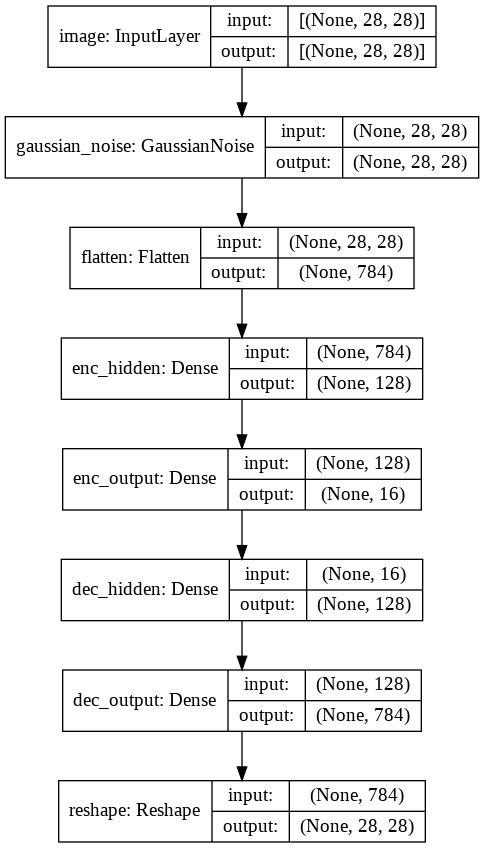

In [44]:
keras.utils.plot_model(noisy_autoencoder, show_shapes=True, show_layer_names=True)

In [33]:
noisy_autoencoder.fit(train_images, train_images,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images, test_images))

Epoch 1/100
235/235 [==============================] - 6s 22ms/step - loss: 0.2440 - val_loss: 0.1670
Epoch 2/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1542 - val_loss: 0.1412
Epoch 3/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1394 - val_loss: 0.1336
Epoch 4/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1337 - val_loss: 0.1287
Epoch 5/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1287 - val_loss: 0.1238
Epoch 6/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1255 - val_loss: 0.1216
Epoch 7/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1234 - val_loss: 0.1199
Epoch 8/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1211 - val_loss: 0.1166
Epoch 9/100
235/235 [==============================] - 5s 21ms/step - loss: 0.1183 - val_loss: 0.1146
Epoch 10/100
235/235 [==============================] - 5s 21ms/step - loss: 0.116

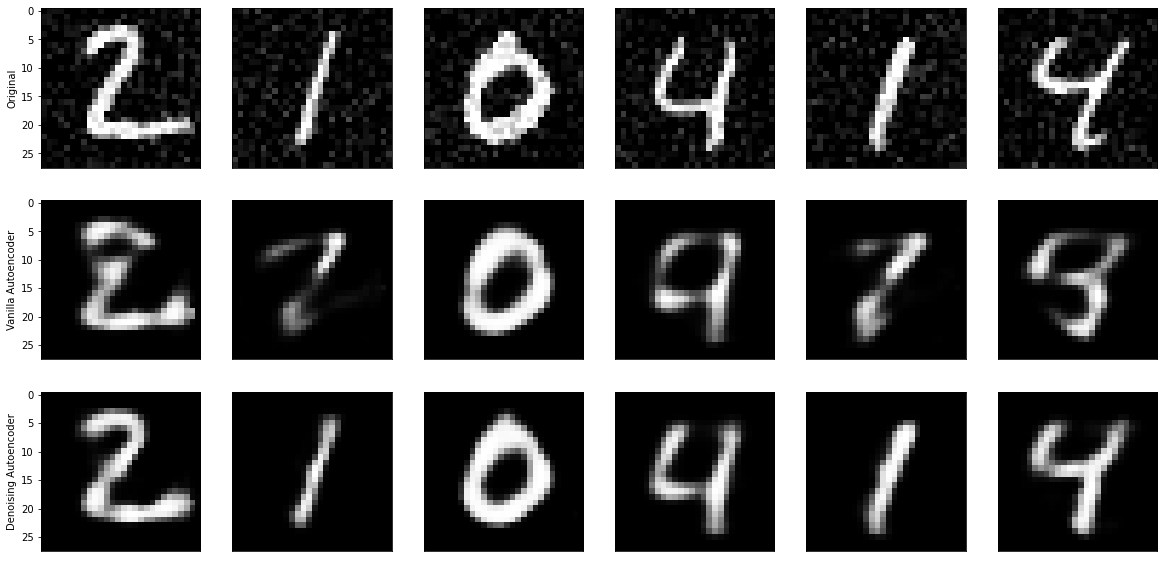

In [34]:
decoded_imgs = autoencoder.predict(x_test_noisy)

decoded_imgs_denoised = noisy_autoencoder.predict(x_test_noisy)

n = 6
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Original")
    else:
        ax.get_yaxis().set_visible(False)
        
    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Vanilla Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
     
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs_denoised[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Denoising Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
    
        
plt.show()

# Noise removal

Autoencoders can have different architectures depending on the goal.

In this example, the focus is on the noise removal. In this case, we do not need the encoder-decoder structure, since our goal is not to compress the images in a lower-dimensional representation bu rather to **generate new images with the noise removed**. This model belongs to the class of **generative** models.

In [35]:
from numpy.random import default_rng
from keras.utils import tf_utils

rng = default_rng()

def salt_and_pepper(inputs, rate):
  shp = tf.shape(inputs)
  mask_select = rng.binomial(n=1, p=rate, size=shp)
  mask_noise = rng.binomial(n=1, p=0.5, size=shp) # salt and pepper have the same chance
  out = inputs * (1-mask_select) + mask_noise * mask_select
  return out

class SaltAndPepperNoise(keras.layers.Layer):

  def __init__(self, rate, **kwargs):
    super(SaltAndPepperNoise, self).__init__(**kwargs)
    self.rate = rate

  def call(self, inputs, training=None):
    def noised():
      shp = keras.backend.shape(inputs)[1:]
      mask_select = keras.backend.random_bernoulli(shape=shp, p=self.rate)
      mask_noise = keras.backend.random_bernoulli(shape=shp, p=0.5) # salt and pepper have the same chance
      out = inputs * (1-mask_select) + mask_noise * mask_select
      return out

    return keras.backend.in_train_phase(noised(), inputs, training=training)

  @tf_utils.shape_type_conversion
  def compute_output_shape(self, input_shape):
    return input_shape

In [36]:
noise_rate = 0.3
train_images_saltpepper = salt_and_pepper(train_images, noise_rate)
test_images_saltpepper = salt_and_pepper(test_images, noise_rate)

In [37]:
input_img = keras.Input(shape=(28, 28), name='noisy_image')

noisy_input = SaltAndPepperNoise(noise_rate, name='salt_and_pepper')(input_img)

encoded = layers.Flatten(name='flatten')(noisy_input)
encoded = layers.Dense(1000, activation='relu', name='dense_hidden')(encoded)
encoded = layers.Dense(784, activation='sigmoid', name='output_image')(encoded)
output = layers.Reshape((28, 28), name='reshape')(encoded)

In [38]:
noise_removal_dae = keras.Model(input_img, output)
noise_removal_dae.compile(optimizer='adam', loss='binary_crossentropy')

In [39]:
print(noise_removal_dae.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noisy_image (InputLayer)     [(None, 28, 28)]          0         
_________________________________________________________________
salt_and_pepper (SaltAndPepp (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_hidden (Dense)         (None, 1000)              785000    
_________________________________________________________________
output_image (Dense)         (None, 784)               784784    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 1,569,784
Trainable params: 1,569,784
Non-trainable params: 0
_________________________________________________

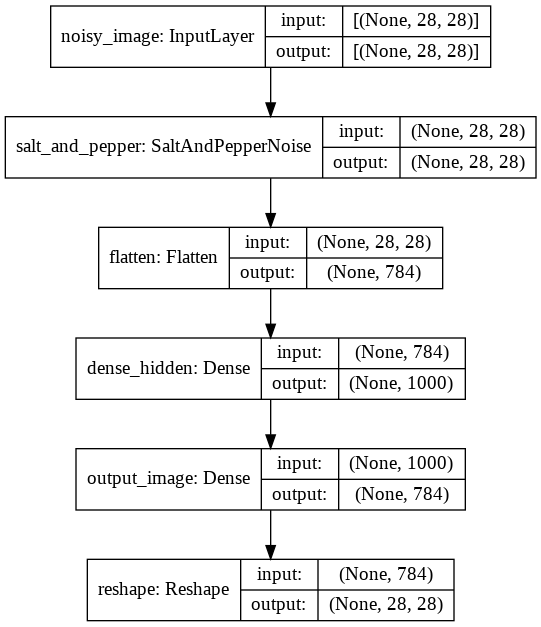

In [45]:
keras.utils.plot_model(noise_removal_dae, show_shapes=True, show_layer_names=True)

In [41]:
noise_removal_dae.fit(train_images, train_images,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images, test_images))

Epoch 1/100
235/235 [==============================] - 14s 57ms/step - loss: 0.1971 - val_loss: 0.1781
Epoch 2/100
235/235 [==============================] - 13s 57ms/step - loss: 0.1431 - val_loss: 0.1561
Epoch 3/100
235/235 [==============================] - 13s 57ms/step - loss: 0.1351 - val_loss: 0.1346
Epoch 4/100
235/235 [==============================] - 13s 57ms/step - loss: 0.1283 - val_loss: 0.1466
Epoch 5/100
235/235 [==============================] - 13s 57ms/step - loss: 0.1247 - val_loss: 0.1366
Epoch 6/100
235/235 [==============================] - 13s 57ms/step - loss: 0.1235 - val_loss: 0.1301
Epoch 7/100
235/235 [==============================] - 13s 57ms/step - loss: 0.1195 - val_loss: 0.1227
Epoch 8/100
235/235 [==============================] - 13s 57ms/step - loss: 0.1178 - val_loss: 0.1287
Epoch 9/100
235/235 [==============================] - 13s 57ms/step - loss: 0.1167 - val_loss: 0.1307
Epoch 10/100
235/235 [==============================] - 13s 57ms/step - l

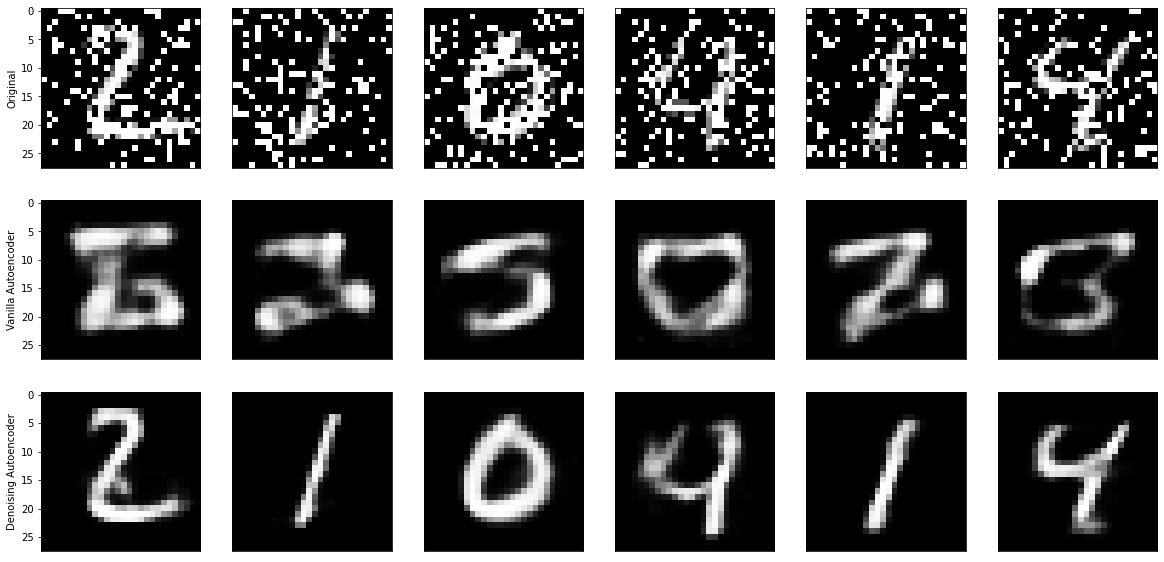

In [42]:
decoded_imgs = autoencoder.predict(test_images_saltpepper)

decoded_imgs_denoised = noise_removal_dae.predict(test_images_saltpepper)

n = 6
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(test_images_saltpepper[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Original")
    else:
        ax.get_yaxis().set_visible(False)
        
    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Vanilla Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
     
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs_denoised[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    if i==1:
        plt.ylabel("Denoising Autoencoder")
    else:
        ax.get_yaxis().set_visible(False)
    
        
plt.show()